Loading data from existing Parquet file...
Applying RDP simplification...


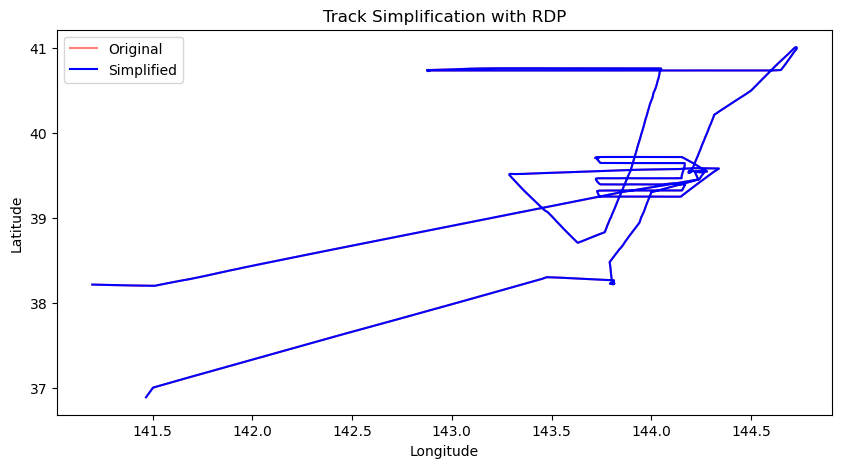

Shapefile saved.


In [4]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp
import geopandas as gpd
from shapely.geometry import LineString
from multiprocessing import Pool
from tqdm import tqdm

# 設定
input_folder = "."
out_parquet = "tracks.parquet"
out_shapefile = "KH-22-10_track.shp"

# kmall から UnixTime, 経度, 緯度 を抽出する関数
def extract_lon_lat_time_from_kmall(kmall_file):
    """mbnavlist を使って .kmall から UnixTime, 経度, 緯度 を抽出"""
    # print('Processing:', kmall_file)
    command = f"mbnavlist -I {kmall_file} -OMXY"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)

    lon_lat_time_data = []
    for line in result.stdout.strip().split("\n"):
        parts = line.split()
        if len(parts) >= 3:
            unix_time = float(parts[0])  # UnixTime
            lon = float(parts[1])        # 経度
            lat = float(parts[2])        # 緯度
            lon_lat_time_data.append((unix_time, lon, lat))

    return lon_lat_time_data

# データを .parquet に保存またはロード

if os.path.exists(out_parquet):
    print("Loading data from existing Parquet file...")
    df = pd.read_parquet(out_parquet)
else:
    # フォルダ内の .kmall ファイルを取得
    kmall_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".kmall")])

    # 並列処理でデータを取得
    with Pool(processes=os.cpu_count()) as pool:
        all_tracks = list(tqdm(pool.imap(extract_lon_lat_time_from_kmall, [os.path.join(input_folder, f) for f in kmall_files]), total=len(kmall_files), desc="Extracting data from kmall"))

    # 取得したデータを結合して DataFrame に
    all_tracks_flattened = [point for track in all_tracks for point in track]
    df = pd.DataFrame(all_tracks_flattened, columns=["UnixTime", "Longitude", "Latitude"])

    # ソートして保存
    df = df.sort_values(by="UnixTime")
    df.to_parquet(out_parquet)
    print("Data saved to Parquet file.")

# RDP アルゴリズムで間引き
def simplify_track(track, epsilon=0.0001):
    """RDP アルゴリズムを適用して航跡データを間引く"""
    return rdp(track, epsilon=epsilon)

# 経度・緯度のペアを取得
all_tracks_coords = df[["Longitude", "Latitude"]].values.tolist()

try:
    print("Applying RDP simplification...")
    simplified_tracks = simplify_track(all_tracks_coords)

    # Matplotlib でプロット
    plt.figure(figsize=(10, 5))
    original = np.array(all_tracks_coords)
    simplified = np.array(simplified_tracks)
    plt.plot(original[:, 0], original[:, 1], 'r-', alpha=0.5, label="Original")
    plt.plot(simplified[:, 0], simplified[:, 1], 'b-', label="Simplified")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.title("Track Simplification with RDP")
    plt.show()

    # Shapefile に保存
    def save_to_shapefile(track, output_path):
        """間引いた経度緯度データを Shapefile として保存"""
        line = LineString(track)
        gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")  # WGS84
        gdf.to_file(output_path, driver="ESRI Shapefile")

    save_to_shapefile(simplified_tracks, out_shapefile)
    print("Shapefile saved.")

except Exception as e:
    print("Error in RDP processing. You can restart from the Parquet file.", str(e))